0 - Libraries

In [1]:
import re
import os
import glob
import csv
from pathlib import Path

import math
import numpy as np
import pandas as pd
import geopandas as gpd
import importlib
import requests
from tqdm import tqdm
import datetime
import pytz
from shapely.geometry import Point
import matplotlib.pyplot as plt
import shapely  # shapely 2.0
from scipy.optimize import minimize_scalar

import pvlib
from pvlib.bifacial import pvfactors
from pvlib.location import Location
from pvlib import tracking
from pvlib.bifacial.pvfactors import pvfactors_timeseries
from pvlib import temperature
from pvlib import pvsystem

import bifacialvf
from bifacialvf import loadVFresults

c:\Users\0davi\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\_compat.py:154: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()
C:\Users\0davi\AppData\Local\Temp\ipykernel_10696\2690456806.py:10: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


In [2]:
import av_potential_utils as av
importlib.reload(av)

<module 'av_potential_utils' from 'c:\\Users\\0davi\\github\\CSET_AV_Chile\\av_potential_utils.py'>

In [3]:
# Configuration
crs_i = 4326
home = os.getcwd()

1 - CREATE WORKING GEODATAFRAME
- creating a geodataframe with points in a raster style
- Load and discretize information based on geodataframes 

= gdf of points with relevant information stored in columns (Base for further Analisis)

In [4]:
# Load geodataframes (prepared in AV_Chile_BBDD.ipynb)
gdf_cl = gpd.read_file("processed\\gdf_cl_rm.shp")          # Region RM borders
gdf_agri = gpd.read_file("processed\\gdf_agri_rm.shp")      # Agricultural ground in RM
gdf_des = gpd.read_file("processed\\gdf_desert_rm.shp")     # Data on desertification for comunes in RM
gdf_preci = gpd.read_file("processed\\gdf_preci_rm.shp")    # Data on precipitation for weather stations in RM

The dataset contains 20 points


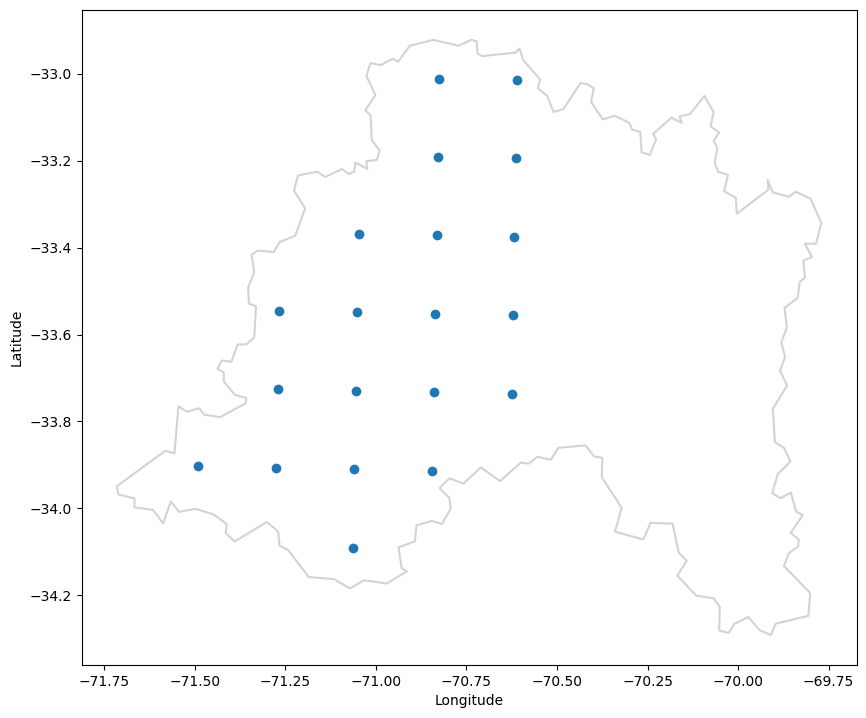

In [55]:
# Functions for handeling of geodataframes
def get_sirgas_crs_point(point):
    """
    Returns the appropriate SIRGAS-Chile UTM zone (CRS) based on the point's longitude.
    
    Parameters:
    -----------
    point : shapely.geometry.Point
        A point with longitude (x).
    
    Returns:
    --------
    str
        EPSG code for the correct UTM zone.
    
    Raises:
    -------
    ValueError:
        If the longitude is outside the supported ranges.
    
    Notes:
    ------
    - Zones covered: 17S, 18S, 19S.
    """
    # Define the SIRGAS-Chile UTM zones
    crs_19S = 'EPSG:32719'  # WGS 84 / UTM zone 19S
    crs_18S = 'EPSG:32718'  # WGS 84 / UTM zone 18S
    crs_17S = 'EPSG:32717'  # WGS 84 / UTM zone 17S
    
    # Function to determine the appropriate CRS based on longitude
    lon = point.x
    if -72 <= lon < -66:
        return crs_19S
    elif -78 <= lon < -72:
        return crs_18S
    elif -84 <= lon < -78:
        return crs_17S
    else:
        raise ValueError("Longitude out of range for defined SIRGAS-Chile UTM zones.")

def get_sirgas_crs_polygon(gdf_polygon):
    """
    Determines the appropriate SIRGAS-Chile UTM zone (CRS) for a polygon based on its bounding box.
    
    Parameters:
    -----------
    gdf_polygon : geopandas.GeoDataFrame
        A GeoDataFrame containing the polygon, expected in any CRS.
    
    Returns:
    --------
    str
        The EPSG code for the determined UTM zone. Defaults to 'EPSG:32719' (central zone) if bounding box spans multiple zones.
    """
    
    # Convert the polygon's CRS to EPSG:4326 (WGS 84)
    shapefile_4326 = gdf_polygon.to_crs(epsg=4326)
    
    # Get the maximum and minimum bounding points
    max_point = Point(shapefile_4326.bounds.max()[["maxx", "maxy"]])
    min_point = Point(shapefile_4326.bounds.min()[["minx", "miny"]])
    
    # Get CRS for both the max and min points
    crs_max = get_sirgas_crs_point(max_point)
    crs_min = get_sirgas_crs_point(min_point)
    
    # If both points are in the same zone, use that CRS; otherwise, use the central zone CRS
    if crs_max == crs_min:
        crs = crs_max
    else:
        crs = 'EPSG:32719'  # Default to the central zone
    
    return crs

def plot_gdf(gdf,gdf_boundaries,column=None, color='Greens', markersize=None):
    """
    Plots a GeoDataFrame with optional boundaries and coloring.

    Parameters:
    -----------
    gdf : geopandas.GeoDataFrame
        The GeoDataFrame containing the main data to plot.
    gdf_boundaries : geopandas.GeoDataFrame
        The GeoDataFrame containing the boundary data to overlay.
    column : str, optional
        Column to color the plot based on its values (default is None).
    color : str, optional
        Color map for the column (default is 'Greens').
    markersize : str, optional
        Column used to set marker size for point geometries (default is None).

    Returns:
    --------
    None
        Displays the plot.
    """
    if column is None:
        if markersize is None:
            ax = gdf.to_crs(crs_i).plot(figsize=(10, 10))
        else:
            ax = gdf.to_crs(crs_i).plot(figsize=(10, 10), markersize=gdf[markersize]/100000)
    else:
        if markersize is None:
            ax = gdf.to_crs(crs_i).plot(figsize=(10, 10), column=column,cmap=color, legend=True) 
        else:
            ax = gdf.to_crs(crs_i).plot(figsize=(10, 10), column=column,cmap=color, markersize=gdf[markersize]/100000, legend=True) 
    gdf_boundaries.to_crs(crs_i).boundary.plot(ax=ax, edgecolor="lightgrey")

    if column is not None:
        plt.title(column +" in dataset")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# Function for creating the point dataset 
# Is filtered to only contain points that are close to agricultural land
def create_working_gdf(shapefile_agri, shapefile_pol, distance_km):
    """
    Creates a GeoDataFrame with points distributed close to the agricultural areas,
    filtered by proximity to political borders, and returns their coordinates.

    Parameters:
    -----------
    shapefile_agri : geopandas.GeoDataFrame
        The GeoDataFrame representing agricultural areas.
    shapefile_pol : geopandas.GeoDataFrame
        The GeoDataFrame representing political borders.
    distance_km : float
        Distance in kilometers to be used for point spacing within the agricultural areas.
    
    Returns:
    --------
    geopandas.GeoDataFrame
        A filtered GeoDataFrame containing the generated points with latitude, longitude, region, and geometry.
    """
    
    # Detect correct CRS for shapefile_agri and convert
    crs = get_sirgas_crs_polygon(shapefile_agri.to_crs(epsg=4326))
    shapefile_agri = shapefile_agri.to_crs(crs)

    # Extract max and min points from the bounding box
    maxx, maxy = shapefile_agri.bounds.max()[["maxx", "maxy"]]
    minx, miny = shapefile_agri.bounds.min()[["minx", "miny"]]
    delta = distance_km * 1000  # Convert distance from kilometers to meters

    # Create a list to store the grid points
    points = []

    # Generate grid points inside the bounding box
    for x in range(0, int(abs((maxx - minx) / delta)) + 1):
        for y in range(0, int(abs((maxy - miny) / delta)) + 1):
            next_x = minx + (x * delta)
            next_y = miny + (y * delta)
            points.append(Point(next_x, next_y))

    # Create GeoDataFrame from points and set the CRS
    point_dataset = gpd.GeoDataFrame(geometry=points, crs=crs)

    # Check and rename 'region' column if it exists in shapefile_agri
    if 'region' in shapefile_agri.columns:
        shapefile_agri = shapefile_agri.rename(columns={'region': 'region_agri'})

    # Spatial join: match points with agricultural areas based on proximity
    gdf_raw = gpd.sjoin_nearest(
        point_dataset, shapefile_agri, how='inner', max_distance=delta / math.sqrt(2),
        lsuffix="l", rsuffix="r", distance_col="dist"
    )

    # Add 'x' column to shapefile_pol for join and filter points by political borders
    shapefile_pol["x"] = shapefile_pol.index
    gdf = gpd.sjoin(left_df=gdf_raw, right_df=shapefile_pol[["x", "region", "geometry"]])

    # Add latitude and longitude in EPSG:4326
    gdf["lat_4326"] = gdf.to_crs(epsg=4326).geometry.y.round(2)
    gdf["long_4326"] = gdf.to_crs(epsg=4326).geometry.x.round(2)

    # Reset index and create final GeoDataFrame
    gdf = gdf.reset_index(drop=True)
    gdf["index"] = gdf.index
    gdf = gdf[['index', "lat_4326", "long_4326", 'region', 'geometry']]

    print(f"The dataset contains {len(gdf)} points")
    return gdf

# Apply function with user-defined distance between points
distance_km = 20
gdf = create_working_gdf(shapefile_agri=gdf_agri,shapefile_pol=gdf_cl,distance_km=distance_km)
plot_gdf(gdf,gdf_cl)

In [56]:
def discretize_input_in_gdf(gdf, gdf_input, column):
    """
    Discretizes the input GeoDataFrame by finding the nearest points from another GeoDataFrame
    and returns the updated GeoDataFrame without the specified column.

    Parameters:
    -----------
    gdf : geopandas.GeoDataFrame
        The GeoDataFrame to be discretized.
    gdf_input : geopandas.GeoDataFrame
        The GeoDataFrame containing input points for discretization.
    column : str
        The name of the column to drop from the resulting GeoDataFrame after the spatial join.

    Returns:
    --------
    geopandas.GeoDataFrame
        The updated GeoDataFrame after spatial joining with the input points.
    """
    
    # Set CRS for both GeoDataFrames
    crs = get_sirgas_crs_polygon(gdf)
    gdf = gdf.to_crs(crs)
    gdf_input = gdf_input.to_crs(crs)

    # Drop the specified column if it exists in gdf
    if column in gdf.columns:
        gdf = gdf.drop(columns=[column])

    # Find nearest point from gdf_input and store in gdf
    gdf = gpd.sjoin_nearest(gdf, gdf_input[[column, "geometry"]], rsuffix="sjoin")
    
    # Drop columns related to the spatial join
    columnsd = gdf.filter(like='sjoin').columns
    gdf = gdf.drop(columns=columnsd)
    
    return gdf

# Get information from further gdf's and store in gdf
gdf = discretize_input_in_gdf(gdf, gdf_input=gdf_des, column="desert")
gdf = discretize_input_in_gdf(gdf, gdf_input=gdf_preci, column="preci_mm")
gdf = discretize_input_in_gdf(gdf, gdf_input=gdf_preci, column="preci_a_mm")

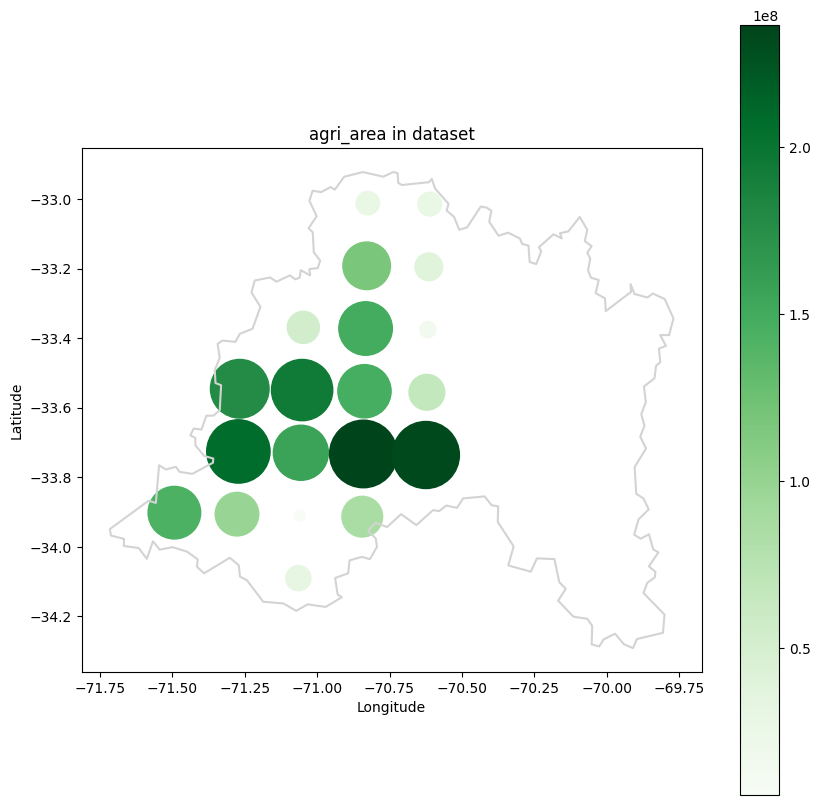

,index,lat_4326,long_4326,region,geometry,desert,preci_mm,preci_a_mm,agri_area,arable land_area,grazing_area,permanent crops_area
0,0,-33.90,-71.49,Metropolitana de Santiago,POINT (269516.334 6245944.838),Grave,454.3,-3.2,1.433710e+08,927.73,9630.22,3779.05
1,1,-33.91,-71.28,Metropolitana de Santiago,POINT (289516.334 6245944.838),Leve,430.4,1.6,9.826971e+07,2340.46,3929.20,3557.40
2,2,-33.73,-71.27,Metropolitana de Santiago,POINT (289516.334 6265944.838),Leve,387.4,-1.7,2.077199e+08,1287.90,15819.08,3664.97
3,3,-33.55,-71.27,Metropolitana de Santiago,POINT (289516.334 6285944.838),Leve,375.6,-4.8,1.781258e+08,1743.97,12569.05,3499.49
4,4,-34.09,-71.06,Metropolitana de Santiago,POINT (309516.334 6225944.838),Grave,479.5,-1.0,3.297000e+07,538.99,1909.72,848.21
5,5,-33.91,-71.06,Metropolitana de Santiago,POINT (309516.334 6245944.838),Grave,479.5,-1.0,5.982202e+06,340.42,140.20,117.60
6,6,-33.73,-71.06,Metropolitana de Santiago,POINT (309516.334 6265944.838),S/I,430.4,1.6,1.570026e+08,2825.65,7905.99,4968.56
7,7,-33.55,-71.05,Metropolitana de Santiago,POINT (309516.334 6285944.838),Leve,327.5,-4.4,1.944763e+08,2631.67,9489.27,7326.56
8,8,-33.37,-71.05,Metropolitana de Santiago,POINT (309516.334 6305944.838),Leve,327.5,-4.4,5.346659e+07,681.49,3342.47,1322.58
9,9,-33.91,-70.84,Metropolitana de Santiago,POINT (329516.334 6245944.838),Leve,377.1,-5.4,8.586501e+07,765.00,6112.49,1708.93


In [57]:
# Agricultural Areas Discretization
# This code discretizes agricultural areas and extracts detailed information about land use types.

# In gdf_agri gdf: Declare agri_type as grazing for "praderas" (could be externalized in gdf preparation)
gdf_agri["agri_type"] = np.where(gdf_agri["crop"] == "ROTACION CULTIVO PRADERA", "grazing", gdf_agri["agri_type"])

# Input parameters
column = "agri_area"
gdf_input = gdf_agri.copy()

# Set CRS for both GeoDataFrames
crs = get_sirgas_crs_polygon(gdf_des)
gdf = gdf.to_crs(crs)
gdf_input = gdf_input.to_crs(crs)

# Prepare data in input gdf
gdf_input = gdf_input.reset_index(drop=True)
gdf_input["ref"] = gdf_input.index
gdf_input[column] = gdf_input.geometry.area

# Drop the specified column from gdf if it exists
if column in gdf.columns:
    gdf = gdf.drop(column, axis=1)

# Find nearest points and store index with suffix "points"
gdf_input = gpd.sjoin_nearest(gdf_input, gdf, rsuffix="points")
gdf_input = gdf_input.drop_duplicates(subset='ref', keep="first")

# Store total agricultural area in gdf
for i in gdf.index:
    gdf.loc[i, column] = float(gdf_input[gdf_input["index_points"] == i][column].sum())

# Extract unique types of agriculture and land class
land_class_unique = gdf_input["land_class"].unique()
agri_type_unique = gdf_input["agri_type"].unique()

# Store areas by agricultural type in gdf
for agri_type in agri_type_unique:
    for i in gdf.index:
        gdf.loc[i, agri_type + "_area"] = float(gdf_input[(gdf_input["index_points"] == i) & (gdf_input["agri_type"] == agri_type)]["area"].sum())

    # Uncomment below if you want to include land class areas
    # for land_class in land_class_unique:
    #     for i in gdf.index:
    #         gdf.loc[i, agri_type + "_" + land_class + "_area"] = float(
    #             gdf_input[(gdf_input["index_points"] == i) & 
    #                        (gdf_input["agri_type"] == agri_type) & 
    #                        (gdf_input["land_class"] == land_class)]["area"].sum()
    #         )

# Plot the resulting GeoDataFrame
plot_gdf(gdf, gdf_cl, column=column, color='Greens', markersize=column)

# Display the GeoDataFrame
gdf

2 - Get Climate data TMYs for all points for further simulations
- check if TMYs exist in local archive 
- if TMY(s) are missing, download TMYs from PVGIS
- update gdf with information from TMYs

= local TMY for every point in gdf 

In [58]:
# Load TMY from local file
def load_TMY(f):
    """
    Load a Typical Meteorological Year (TMY) dataset from a CSV file and process it.

    Parameters:
    -----------
    f : str
        The file path of the CSV containing the TMY data.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the TMY data with an added time column.
    """
    # Load TMY data from CSV file
    tmy = pd.read_csv(f, encoding='latin-1')

    # Create a time range for the year 2022 and add it to the DataFrame
    tmy["time"] = pd.date_range(start="2022-01-01 00:00", end="2022-12-31 23:00", freq="h")

    # Convert specific info values to float
    for info in ["lat_4326", "long_4326", "altitude"]:
        tmy.loc[tmy["info"] == info, "info_values"] = float(tmy.loc[tmy["info"] == info, "info_values"])

    return tmy

# update information in gdf 
def update_gdf_from_TMY(gdf, cord, tmy):
    """
    Update the GeoDataFrame with altitude, PVGIS data, and total GHI from a TMY dataset 
    based on specified coordinates.

    Parameters:
    -----------
    gdf : geopandas.GeoDataFrame
        The GeoDataFrame to be updated.
    cord : list
        A list containing latitude and longitude coordinates.
    tmy : pandas.DataFrame
        The TMY dataset containing meteorological information.

    Returns:
    --------
    geopandas.GeoDataFrame
        The updated GeoDataFrame with new information from the TMY dataset.
    """
    lat_4326 = float(cord[0][0])
    long_4326 = float(cord[0][1])
    
    # Update altitude and PVGIS data for the matching coordinates
    condition = (gdf["long_4326"] == long_4326) & (gdf["lat_4326"] == lat_4326)
    
    gdf.loc[condition, "altitude"] = tmy.loc[tmy['info'] == "altitude", "info_values"].iloc[0]
    gdf.loc[condition, "PVGIS_dl"] = tmy.loc[tmy['info'] == "PVGIS_dl", "info_values"].iloc[0]
    gdf.loc[condition, "GHI_KWh/a"] = tmy.ghi.sum() / 1000

    return gdf

# get TMY from PVGIS
def get_TMY(lat_4326, long_4326, tz='America/Santiago', directory="data\\PVGIS_TMY\\", usehorizon=True):
    """
    Retrieve Typical Meteorological Year (TMY) data from the PVGIS API for specified latitude and longitude.

    Parameters:
    -----------
    lat_4326 : float
        Latitude in WGS 84 coordinate system.
    long_4326 : float
        Longitude in WGS 84 coordinate system.
    tz : str, optional
        Timezone to convert the timestamps (default is 'America/Santiago').
    directory : str, optional
        Directory to save the TMY CSV file (default is "data\\PVGIS_TMY\\").
    usehorizon : bool, optional
        If True, uses the horizon data from PVGIS (default is True).

    Returns:
    --------
    tuple
        A tuple containing:
        - pandas.DataFrame: TMY data.
        - float: Altitude of the location.
        - str: Download information or error message.
    """
    lat_4326 = round(lat_4326, 2)
    long_4326 = round(long_4326, 2)

    try: 
        # API request            
        data_pvgis = pvlib.iotools.get_pvgis_tmy(
            lat_4326, long_4326, outputformat='json', 
            usehorizon=usehorizon, userhorizon=None, 
            startyear=None, endyear=None, 
            url='https://re.jrc.ec.europa.eu/api/v5_2/', 
            map_variables=None, timeout=30
        )
        
        # Get altitude and TMY data
        tmy_pvg_r = data_pvgis[0]
        altitude = data_pvgis[2].get("location").get("elevation")

        # Adapt to local timezone
        timezone = pytz.timezone(tz)
        dt = datetime.datetime.utcnow()
        offset_hours = timezone.utcoffset(dt).seconds / 3600.0
        if offset_hours > 12:
            offset_hours -= 24
        if offset_hours < 0:
            offset_hours = int(-offset_hours)
            # Extract the first rows according to the time offset
            first_rows = tmy_pvg_r.head(offset_hours)
            tmy_pvg_r = tmy_pvg_r.drop(tmy_pvg_r.index[:offset_hours])
            # Concatenate the modified DataFrame and the first three rows
            tmy_pvg = pd.concat([tmy_pvg_r, first_rows])   
        else:
            print("TMY download only for South America")

        tmy_pvg["time"] = pd.date_range(start="2022-01-01 00:00", end="2022-12-31 23:00", freq="h", tz=tz)
        tmy_pvg.index = tmy_pvg["time"]

        # Information on PVGIS Download
        if (tmy_pvg["G(h)"].sum() < 1):
            download_info = "missing solar data"
        elif (tmy_pvg["WS10m"].sum() < 1) | (tmy_pvg["T2m"].sum() < 1):
            download_info = "missing climate data"
        else:
            download_info = "ok"

        # Process TMY data: Rename for PVLib
        cols_to_use = ["time", "T2m", "G(h)", "Gb(n)", "Gd(h)", "IR(h)", "WS10m", "RH", "SP"] 
        pvlib_column_names = ["time", "temp_air", "ghi", "dni", "dhi", "lwr_u", "wind_speed", "rh", "sp"] 
        tmy_pvg = tmy_pvg[cols_to_use]
        tmy_pvg.columns = pvlib_column_names
        
        location = Location(lat_4326, long_4326, tz, altitude)
        # Get solar azimuth and zenith to store in TMY
        solar_position = location.get_solarposition(times=tmy_pvg.index)
        tmy_pvg["azimuth"] = solar_position["azimuth"] 
        tmy_pvg["zenith"] = solar_position["zenith"] 
        tmy_pvg["elevation"] = 90 - tmy_pvg["zenith"]
        tmy_pvg["apparent_zenith"] = solar_position["apparent_zenith"] 
        tmy_pvg = tmy_pvg.reset_index(drop=True)
        
        # Store meta data
        meta_data = [
            (0, "lat_4326", lat_4326),
            (1, "long_4326", long_4326),
            (2, "altitude", altitude),
            (3, "PVGIS_dl", download_info)
        ]
        
        for index, info, value in meta_data:
            tmy_pvg.loc[index, "info"] = info
            tmy_pvg.loc[index, "info_values"] = value

        # Save as CSV
        outFileName = f"TMY_{lat_4326}_{long_4326}.csv"
        tmy_pvg.to_csv(directory + outFileName, sep=',', encoding='latin-1', index=False)

    except requests.HTTPError as err:
        tmy_pvg = None
        altitude = None
        download_info = str(err)

    return tmy_pvg, altitude, download_info

# use gdf to realize automized download of TMYS from 
def get_TMYs_from_gdf(gdf, tz='America/Santiago', directory="data\\PVGIS_TMY\\", tmy_all=None):
    """
    Retrieve Typical Meteorological Year (TMY) data for each location in a GeoDataFrame.

    Parameters:
    -----------
    gdf : GeoDataFrame
        GeoDataFrame containing geometries of locations to retrieve TMY data for.
    tz : str, optional
        Timezone for TMY data (default is 'America/Santiago').
    directory : str, optional
        Directory to save the TMY CSV file (default is "data\\PVGIS_TMY\\").
    tmy_all : optional
        Placeholder for future enhancements or data storage; currently not used.

    Returns:
    --------
    GeoDataFrame
        Updated GeoDataFrame with TMY data for each location.
    """
    crs_gdf = gdf.crs
    gdf = gdf.to_crs(epsg=4326)
    
    # Create latitude and longitude columns
    gdf["lat_4326"] = gdf.geometry.y.round(2)
    gdf["long_4326"] = gdf.geometry.x.round(2)
    
    for i in tqdm(gdf.index):
        if gdf.loc[i, "PVGIS_dl"] != "ok": 
            lat_4326 = gdf.loc[i, "lat_4326"]
            long_4326 = gdf.loc[i, "long_4326"]
            tmy_pvg, altitude, download_info = get_TMY(lat_4326, long_4326, tz=tz)

            if download_info == "ok":
                gdf.loc[i, "altitude"] = altitude
                gdf.loc[i, "PVGIS_dl"] = download_info
                gdf.loc[i, "GHI_KWh/a"] = tmy_pvg["ghi"].sum() / 1000
            else:
                gdf.loc[i, "GHI_KWh/a"] = None
                gdf.loc[i, "altitude"] = altitude
                gdf.loc[i, "PVGIS_dl"] = download_info

    gdf = gdf.to_crs(crs_gdf)

    # Print download summary
    num_failed_downloads = len(gdf[gdf['PVGIS_dl'] != "ok"])
    print(f"PVGIS Download finished: {num_failed_downloads} locations without (complete) TMY data")
    
    
    return gdf


In [59]:
# Get all coordinates from gdf
coordinates_list = list(zip(gdf['lat_4326'].round(2).astype(str), gdf['long_4326'].round(2).astype(str)))
gdf["PVGIS_dl"] = np.nan
gdf["altitude"] = np.nan
gdf["GHI_KWh/a"] = np.nan

# Get info on available csv files
directory_TMYs="data\\PVGIS_TMY\\"
path = home+"\\"+directory_TMYs
tmy_files = glob.glob(path + "\*.csv")

# Pattern of file names to extract coordinates
pattern = r'([-+]?\d+\.\d+)_([-+]?\d+\.\d+)\.csv'

# loop over the list of csv files, load info from matched TMYs and delete not-matched TMYs
for f in tqdm(tmy_files):
    # Using re.findall() to extract the coordinates
    cord = re.findall(pattern, f)
    try:
        index = coordinates_list.index(cord[0])
        tmy = load_TMY(f)
        gdf = update_gdf_from_TMY(gdf,cord,tmy)
    except:
        os.remove(f)

# get TMY
gdf = get_TMYs_from_gdf(gdf, tz='America/Santiago', directory="data\\PVGIS_TMY\\", tmy_all=None)

# get updated list of tmy files
tmy_files = glob.glob(path + "\*.csv")

gdf

100%|██████████| 20/20 [00:00<00:00, 170154.32it/s]

PVGIS Download finished: 0 locations without (complete) TMY data


,index,lat_4326,long_4326,region,geometry,desert,preci_mm,preci_a_mm,agri_area,arable land_area,grazing_area,permanent crops_area,PVGIS_dl,altitude,GHI_KWh/a
0,0,-33.90,-71.49,Metropolitana de Santiago,POINT (269516.334 6245944.838),Grave,454.3,-3.2,1.433710e+08,927.73,9630.22,3779.05,ok,315.0,1971.70735
1,1,-33.91,-71.28,Metropolitana de Santiago,POINT (289516.334 6245944.838),Leve,430.4,1.6,9.826971e+07,2340.46,3929.20,3557.40,ok,583.0,2056.70213
2,2,-33.73,-71.27,Metropolitana de Santiago,POINT (289516.334 6265944.838),Leve,387.4,-1.7,2.077199e+08,1287.90,15819.08,3664.97,ok,124.0,2053.09519
3,3,-33.55,-71.27,Metropolitana de Santiago,POINT (289516.334 6285944.838),Leve,375.6,-4.8,1.781258e+08,1743.97,12569.05,3499.49,ok,265.0,2075.08069
4,4,-34.09,-71.06,Metropolitana de Santiago,POINT (309516.334 6225944.838),Grave,479.5,-1.0,3.297000e+07,538.99,1909.72,848.21,ok,1098.0,1924.82472
5,5,-33.91,-71.06,Metropolitana de Santiago,POINT (309516.334 6245944.838),Grave,479.5,-1.0,5.982202e+06,340.42,140.20,117.60,ok,954.0,1933.61006
6,6,-33.73,-71.06,Metropolitana de Santiago,POINT (309516.334 6265944.838),S/I,430.4,1.6,1.570026e+08,2825.65,7905.99,4968.56,ok,288.0,2028.52290
7,7,-33.55,-71.05,Metropolitana de Santiago,POINT (309516.334 6285944.838),Leve,327.5,-4.4,1.944763e+08,2631.67,9489.27,7326.56,ok,639.0,1871.28033
8,8,-33.37,-71.05,Metropolitana de Santiago,POINT (309516.334 6305944.838),Leve,327.5,-4.4,5.346659e+07,681.49,3342.47,1322.58,ok,658.0,2083.92847
9,9,-33.91,-70.84,Metropolitana de Santiago,POINT (329516.334 6245944.838),Leve,377.1,-5.4,8.586501e+07,765.00,6112.49,1708.93,ok,968.0,1936.92766


3 - Technical and Economic modelling (based on local TMYs)
- Set Parameters of AV Systems
- Shadow Simulation with optional optimization of row distance
- PV yield simulation
- EV simulation
- LCOE simulation

= gdf with raw results

In [60]:
## TECHNICAL AND FINANCIAL PARAMETERS

# PV Module Data
length_module = 2.384 # m
width_module = 1.303 # m
cap_module = 0.64 # kWp 
PV_W_per_m2 = cap_module * 1000 / (length_module * width_module)

# AV Configurations
input = pd.DataFrame({"parameter": ["tracking", "pvrow_azimuth", "pvrow_tilt", "pvrow_distance","pvrow_width", "pvrow_height", "bifaciality", "capex", "opex"]}).set_index("parameter")
input["AV_arable land"] = [False, 0, 20, 7, 2*width_module, 1, 0.9, 700, 10]
input["AV_grazing"] = [False, 0, 20, 5, 2*width_module, 2, 0.9, 750, 12]
input["AV_permanent crops"] = [False, 90, 20, 5, 2*width_module, 4, 0.9, 1000, 16]

# Get cases based on input columns
AV_types = input.columns.values

# Show input table
input

,AV_arable land,AV_grazing,AV_permanent crops
parameter,,,
tracking,False,False,False
pvrow_azimuth,0,0,90
pvrow_tilt,20,20,20
pvrow_distance,7,5,5
pvrow_width,2.606,2.606,2.606
pvrow_height,1,2,4
bifaciality,0.9,0.9,0.9
capex,700,750,1000
opex,10,12,16


In [61]:
# Get AV Type based on largest agricultural area by use
def get_av_type(gdf_row):
    max_col = gdf_row[['arable land_area', 'grazing_area', 'permanent crops_area']].idxmax()
    return "AV_" + max_col.replace('_area', '')  # Präfix hinzufügen und "_area" entfernen

# Anwenden der Funktion auf jede Zeile und neue Spalte "apv_type" erstellen
gdf['AV_type'] = gdf.apply(get_av_type, axis=1)
gdf

,index,lat_4326,long_4326,region,geometry,desert,preci_mm,preci_a_mm,agri_area,arable land_area,grazing_area,permanent crops_area,PVGIS_dl,altitude,GHI_KWh/a,AV_type
0,0,-33.90,-71.49,Metropolitana de Santiago,POINT (269516.334 6245944.838),Grave,454.3,-3.2,1.433710e+08,927.73,9630.22,3779.05,ok,315.0,1971.70735,AV_grazing
1,1,-33.91,-71.28,Metropolitana de Santiago,POINT (289516.334 6245944.838),Leve,430.4,1.6,9.826971e+07,2340.46,3929.20,3557.40,ok,583.0,2056.70213,AV_grazing
2,2,-33.73,-71.27,Metropolitana de Santiago,POINT (289516.334 6265944.838),Leve,387.4,-1.7,2.077199e+08,1287.90,15819.08,3664.97,ok,124.0,2053.09519,AV_grazing
3,3,-33.55,-71.27,Metropolitana de Santiago,POINT (289516.334 6285944.838),Leve,375.6,-4.8,1.781258e+08,1743.97,12569.05,3499.49,ok,265.0,2075.08069,AV_grazing
4,4,-34.09,-71.06,Metropolitana de Santiago,POINT (309516.334 6225944.838),Grave,479.5,-1.0,3.297000e+07,538.99,1909.72,848.21,ok,1098.0,1924.82472,AV_grazing
5,5,-33.91,-71.06,Metropolitana de Santiago,POINT (309516.334 6245944.838),Grave,479.5,-1.0,5.982202e+06,340.42,140.20,117.60,ok,954.0,1933.61006,AV_arable land
6,6,-33.73,-71.06,Metropolitana de Santiago,POINT (309516.334 6265944.838),S/I,430.4,1.6,1.570026e+08,2825.65,7905.99,4968.56,ok,288.0,2028.52290,AV_grazing
7,7,-33.55,-71.05,Metropolitana de Santiago,POINT (309516.334 6285944.838),Leve,327.5,-4.4,1.944763e+08,2631.67,9489.27,7326.56,ok,639.0,1871.28033,AV_grazing
8,8,-33.37,-71.05,Metropolitana de Santiago,POINT (309516.334 6305944.838),Leve,327.5,-4.4,5.346659e+07,681.49,3342.47,1322.58,ok,658.0,2083.92847,AV_grazing
9,9,-33.91,-70.84,Metropolitana de Santiago,POINT (329516.334 6245944.838),Leve,377.1,-5.4,8.586501e+07,765.00,6112.49,1708.93,ok,968.0,1936.92766,AV_grazing


3.1 - Shadow Analisis

3.1.1 - Helper Functions

In [62]:
# Functions for viewfactors compatibility, PAR calculations and Light Homogenity Index
def prep_TMY_vf(tmy):
    """
    Prepares TMY data for view factor (VF) analysis (format needed for bifacialvf).

    Parameters:
    -----------
    tmy : DataFrame
        Typical Meteorological Year (TMY) data containing irradiance and atmospheric information.

    Returns:
    --------
    DataFrame
        Processed TMY data with radians conversion and extracted variables.
    """
    myTMY3 = tmy.copy()
    myTMY3 = myTMY3[myTMY3["elevation"] > 0]  # Filter for positive elevation
    myTMY3["azimuth"] = np.radians(myTMY3["azimuth"]) 
    myTMY3["zenith"] = np.radians(myTMY3["zenith"]) 
    myTMY3["elevation"] = np.radians(myTMY3["elevation"]) 
    myTMY3["GHI"] = myTMY3["ghi"]
    myTMY3["DNI"] = myTMY3["dni"]
    myTMY3["DHI"] = myTMY3["dhi"]
    myTMY3.index = myTMY3["time"]
    return myTMY3

def read_vf_result(resultfilepath):
    """
    Reads and processes the result file from the shadow simulation.

    Parameters:
    -----------
    resultfilepath : str
        Path to the shadow simulation result file.

    Returns:
    --------
    tuple
        Tuple containing the original data, ground irradiance values, and a DataFrame with GHI and average ground irradiance.
    """
    data, metadata = loadVFresults(resultfilepath)
    data.index = pd.to_datetime(data['date'], utc=True)
    groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
    
    df = pd.DataFrame()
    df["ghi"] = data["ghi"]
    df["ghi_apv"] = groundIrrads.mean(axis=1)
    return data, groundIrrads, df

def ghi_to_PAR(df, ratio, conversion_factor):
    """
    Converts GHI data to PAR (Photosynthetically Active Radiation).

    Parameters:
    -----------
    df : DataFrame
        DataFrame containing GHI values.
    ratio : float
        Ratio for GHI to PAR conversion.
    conversion_factor : float
        Factor for adjusting units.

    Returns:
    --------
    DataFrame
        DataFrame containing converted PAR values.
    """
    df_ghi = df.filter(like='ghi')
    df_ghi.columns = df_ghi.columns.str.replace('ghi', 'PAR')
    df_PAR = df_ghi * ratio * conversion_factor
    return df_PAR

def apply_LSP(df, LSP):
    """
    Applies Light Saturation Point (LSP) limit to PAR values.

    Parameters:
    -----------
    df : DataFrame
        DataFrame containing PAR values.
    LSP : float
        Light Saturation Point value.

    Returns:
    --------
    DataFrame
        Updated DataFrame with LSP applied.
    """
    for col in df.filter(like='PAR').columns:
        df[col + '_LSP'] = np.where(df[col] > LSP, LSP, df[col])
    return df

def PAR_integral(df):
    """
    Integrates PAR values over time.

    Parameters:
    -----------
    df : DataFrame
        DataFrame containing PAR values.

    Returns:
    --------
    DataFrame
        Daily summed PAR values converted to mol/m²/hour.
    """
    df_PAR = df.filter(like='PAR')
    df_PAR = df_PAR / 1e6 * 3600  # convert to mol/m²/hour
    df_PAR_d = df_PAR.groupby(pd.Grouper(freq='D')).sum()
    return df_PAR_d

def apply_DLI(df, DLI):
    """
    Applies Daily Light Integral (DLI) limit to LSP values.

    Parameters:
    -----------
    df : DataFrame
        DataFrame containing LSP values.
    DLI : float
        Daily Light Integral value.

    Returns:
    --------
    DataFrame
        Updated DataFrame with DLI applied.
    """
    for col in df.filter(like='LSP').columns:
        df[col + '_DLI'] = np.where(df[col] > DLI, DLI, df[col])
    return df

def get_LHI(groundIrrads_monthly):
    """
    Calculates Light Homogeneity Index (LHI) from monthly ground irradiance data.

    Parameters:
    -----------
    groundIrrads_monthly : DataFrame
        Monthly ground irradiance values.

    Returns:
    --------
    float
        Average Light Homogeneity Index rounded to two decimal places.
    """
    lhis = []
    for col in groundIrrads_monthly.columns:
        cv = groundIrrads_monthly[col].std() / groundIrrads_monthly[col].mean()
        lhi = 100 * (1 - cv)
        lhis.append(lhi)
    return round(np.mean(lhis), 2)


3.1.2 - Modified Function for Viewfactors Shadow Simulation 

In [63]:
# Modification of the original simulate function from the bifacialvf libary: https://github.com/NREL/bifacialvf/blob/main/bifacialvf/bifacialvf.py#L226
from bifacialvf.vf import getBackSurfaceIrradiances, getFrontSurfaceIrradiances, getGroundShadeFactors
from bifacialvf.vf import getSkyConfigurationFactors, trackingBFvaluescalculator, rowSpacing
from bifacialvf.sun import  perezComp,  sunIncident, sunrisecorrectedsunposition #, hrSolarPos, solarPos,
from bifacialvf.analysis import analyseVFResultsBilInterpol, analyseVFResultsPVMismatch

# Added variables: spacing_analisis=False, shadow_only=True, fix_csr=0.05
#   spacing_anilisis = False --> doesn't perform spacing anlisis and doesn't print result
#   shadow_only = True --> doesn't perform computation of irradiation conditions on PV panels
#   fix_csr = 0.05 --> Avoids Perez Computation for diffuse irradiation condiations, but applies fix rate for circumsolar diffuse irradiation
# avoids prints of results
def simulate_vf(myTMY3, meta, writefiletitle=None, tilt=0, sazm=180, 
             clearance_height=None, hub_height = None, 
             pitch=None, rowType='interior', transFactor=0.01, sensorsy=6, 
             PVfrontSurface='glass', PVbackSurface='glass', albedo=None,  
             tracking=False, backtrack=True, limit_angle=45,
             calculatePVMismatch=False, cellsnum= 72, 
             portraitorlandscape='landscape', bififactor = 1.0,
             calculateBilInterpol=False, BilInterpolParams=None,
             deltastyle='TMY3', agriPV=True, spacing_analisis=False, shadow_only=True, fix_csr=0.05):

        '''
      
        Original Description
        -----------
        Main function to run the bifacialvf routines 
    
        Parameters
        ---------- 
        myTMY3 (pd.DataFrame): A pandas DataaFrame containing for each timestep columns:
            DNI, DHI, it can also have DryBulb, Wspd, zenith, azimuth,
        meta (dict): A dictionary conatining keys: 'latitude', 'longitude', 'TZ', 'Name'
        writefiletitle:  name of output file
        tilt:    tilt angle in degrees.  Not used for tracking
        sazm:    surface azimuth orientation in degrees east of north. For tracking this is the tracker axis orientation
        C:       normalized ground clearance.  For trackers, this is the module height at zero tilt
        pitch:     row-to-row normalized distance.  = 1/GCR
        transFactor:   PV module transmission fraction.  Default 1% (0.01)
        sensorsy:      Number of points along the module chord to return irradiance values.  Default 6 (1-up landscape module)
        limit_angle:     1-axis tracking maximum limits of rotation
        tracking, backtrack:  boolean to enable 1-axis tracking and pvlib backtracking algorithm, respectively
        albedo:     If a value is passed, that value will be used for all the simulations.
                    If None is passed (or albedo argument is not passed), program will search the 
                    TMY file for the "Albe (unitless)" column and use those values

        New Parameters: 
        # Dictionary input example:
        # calculateBilInterpol = {'interpolA':0.005, 'IVArray':None, 'beta_voc_all':None, 'm_all':None, 'bee_all':None}

        
        Returns
        -------
        none
        '''    


# CHECKING INPUT VARIABLES
        if (clearance_height == None) & (hub_height != None):
            clearance_height = hub_height
            if tracking == False:
                print('Warning: hub_height passed and is being used as ',
                      'clearance_height for the fixed_tilt routine.')
        elif (clearance_height == None) & (hub_height == None):
            raise Exception('No row distance specified in either D or pitch') 
        elif (clearance_height != None) & (hub_height == None): 
            if tracking == True:
#                print('Warning: clearance_height passed and is being used as ',
#                      'hub_height for the tracking routine')
                dummy = 0
        else:
#            print('Warning: clearance_height and hub_height passed in. Using ' 
#                  + ('hub_height' if tracking else 'clearance_height') )
            if tracking == True:
                clearance_height = hub_height
        
        C=clearance_height
        heightlabel = 'Clearance_Height'

        if tracking == True:
            axis_tilt = 0  # algorithm only allows for zero north-south tilt with SAT
            #limit_angle = 45  # maximum tracker rotation 
            axis_azimuth=sazm    # axis_azimuth is degrees east of North
            tilt = 0            # start with tracker tilt = 0
            hub_height = C      # Ground clearance at tilt = 0.  C >= 0.5
            stowingangle = 90
            if hub_height < 0.5:
                print('Warning: tracker hub height C < 0.5 may result in ground clearance errors')
            heightlabel = 'Hub_Height'

        D = pitch - math.cos(tilt / 180.0 * math.pi)

        if writefiletitle == None:
            writefiletitle = "data/Output/TEST.csv"
        

# ADDITIOAL INFORMATION
        noRows, noCols = myTMY3.shape
        lat = meta['latitude']; lng = meta['longitude']; tz = meta['TZ']
        try:
            name = meta['state-prov'] #TMY3
        except KeyError:  
            name = lat+"_"+lng
        
        ## infer the data frequency in minutes
        dataInterval = (myTMY3.index[1]-myTMY3.index[0]).total_seconds()/60

# CHECK FOR SOLAR POSITION DATA
        if not (('azimuth' in myTMY3) and ('zenith' in myTMY3) and ('elevation' in myTMY3)):
            print("no solar position data found")
        
# COMPUTE TRACKING DATA
        if tracking == True:               
            if not (('trackingdata_surface_tilt' in myTMY3) and ('trackingdata_surface_azimuth' in myTMY3)):
                gcr=1/pitch  
                trackingdata = pvlib.tracking.singleaxis(np.degrees(myTMY3['zenith']), 
                                                         np.degrees(myTMY3['azimuth']),
                                                         axis_tilt, axis_azimuth, 
                                                         limit_angle, backtrack, gcr)
                
                trackingdata['surface_tilt'] = trackingdata.surface_tilt.fillna(stowingangle)
                myTMY3['trackingdata_surface_tilt'] = trackingdata['surface_tilt']         
                myTMY3['trackingdata_surface_azimuth'] = trackingdata['surface_azimuth']            
            [myTMY3['C'], myTMY3['D']] = trackingBFvaluescalculator(myTMY3['trackingdata_surface_tilt'], hub_height, pitch)

# ALBEDO
        # Check what Albedo to see:
        if albedo == None:
            if 'Alb' in myTMY3:
                print("Using albedo from TMY3 file.")
                print("Note that at the moment, no validation check is done",
                      "in the albedo data, so we assume it's correct and valid.\n")
                useTMYalbedo = True
            else:
                print("No albedo value set or included in TMY3 file", 
                      "(TMY Column name 'Alb (unitless)' expected)",
                      "Setting albedo default to 0.2\n ")
                albedo = 0.2
                useTMYalbedo=False
        else:
            if 'Alb' in myTMY3:
                print("Albedo value passed, but also present in TMY3 file. ",
                      "Using albedo value passed. To use the ones in TMY3 file",
                      "re-run simulation with albedo=None\n")
            useTMYalbedo=False

# OPTIMAL SPACING ANALISIS
        if spacing_analisis == True:
            ## Distance between rows for no shading on Dec 21 at 9 am
            print( " ")
            print( "********* ")
            print( "Running Simulation for TMY3: ")
            print( "Location:  ", name)
            print( "Lat: ", lat, " Long: ", lng, " Tz ", tz)
            print( "Parameters: tilt: ", tilt, "  Sazm: ", sazm, "   ", 
                heightlabel, ": ", C, "  Pitch: ", pitch, "  Row type: ", rowType, 
                "  Albedo: ", albedo)
            print( "Saving into", writefiletitle)
            print( " ")
            print( " ")
            
            DD = rowSpacing(tilt, sazm, lat, lng, tz, 9, 0.0);          ## Distance between rows for no shading on Dec 21 at 9 am
            print( "Distance between rows for no shading on Dec 21 at 9 am solar time = ", DD)
            print( "Actual distance between rows = ", D  )
            print( " ")
    

# WRITING RESULTS    
        ## Create WriteFile and write labels at this time
        
        #check that the save directory exists, unless it's in root
        savedirectory = os.path.dirname(writefiletitle)
        if ( (not os.path.exists(savedirectory)) and (savedirectory != '')):
            os.makedirs(savedirectory)
                  
        with open (writefiletitle,'w') as csvfile:
            sw = csv.writer(csvfile, delimiter=',', quotechar='|', 
                            quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
            # Write Simulation Parameters (from setup file)            
            if tracking==False and backtrack==True:
                print("Warning: tracking=False, but backtracking=True. ",
                      "Setting backtracking=False because it doesn't make ",
                      "sense to backtrack on fixed tilt systems.")
                backtrack = False
            outputheader=['Latitude(deg)','Longitude(deg)', 'Time Zone','Tilt(deg)', 
                         'PV Azimuth(deg)',heightlabel, 'Pitch', 'RowType(first interior last single)',
                         'TransmissionFactor(open area fraction)','sensorsy(# hor rows in panel)', 
                         'PVfrontSurface(glass or ARglass)', 'PVbackSurface(glass or ARglass)',
                         'Albedo',  'Tracking', 'backtracking']
            outputheadervars=[lat, lng, tz, tilt, sazm, clearance_height, pitch, 
                              rowType, transFactor, sensorsy, PVfrontSurface,
                             PVbackSurface, albedo, tracking, backtrack]           
            sw.writerow(outputheader)
            sw.writerow(outputheadervars)
            
            # Write Results names"

            if shadow_only == True:
                outputtitles=['date', 'DNI', 'DHI', "beam", "circ_dif", "iso_dif",'ghi', 'inc',  'azm',
                          'albedo', 'Tamb', 'VWind']    
                
            else:
                allrowfronts=[]
                allrowbacks=[]
                for k in range(0, sensorsy):
                    allrowfronts.append("No_"+str(k+1)+"_RowFrontGTI")
                    allrowbacks.append("No_"+str(k+1)+"_RowBackGTI")      
                outputtitles=['date', 'DNI', 'DHI', 
                          'albedo', 'decHRs', 'ghi', 'inc', 'zen', 'azm', 'pvFrontSH', 
                         'aveFrontGroundGHI', 'GTIfrontBroadBand', 'pvBackSH', 
                         'aveBackGroundGHI', 'GTIbackBroadBand', 'maxShadow', 'Tamb', 'VWind']
                outputtitles+=allrowfronts
                outputtitles+=allrowbacks

            if tracking == True:
#                print( " ***** IMPORTANT --> THIS SIMULATION Has Tracking Activated")
#                print( "Backtracking Option is set to: ", backtrack)
                outputtitles+=['tilt']
                outputtitles+=['sazm']
                outputtitles+=['height']
                outputtitles+=['D']

            if agriPV:
#                print("Saving Ground Irradiance Values for AgriPV Analysis. ")
                outputtitles+=['Ground Irradiance Values']
            sw.writerow(outputtitles)
            
# GET SKY CONFIG FACTORS            
            if tracking==False:        
                ## Sky configuration factors are the same for all times, only based on geometry and row type
                [rearSkyConfigFactors, frontSkyConfigFactors] = getSkyConfigurationFactors(rowType, tilt, C, D)       ## Sky configuration factors are the same for all times, only based on geometry and row type

# START OF SIMULATION
            ## Loop through file.  TODO: replace this with for loop.
            rl = 0
            for rl in range(noRows):
# GET CLIMATE DATA AND SOLAR POSITION                
                myTimestamp=myTMY3.index[rl]
                hour = myTimestamp.hour
                minute = myTimestamp.minute
                dni = myTMY3.DNI.iloc[rl]
                dhi = myTMY3.DHI.iloc[rl]
                if 'temp_air' in myTMY3: Tamb=myTMY3.temp_air.iloc[rl]
                else: Tamb=0	            
                if 'wind_speed' in myTMY3: VWind = myTMY3.wind_speed.iloc[rl]	           
                else: VWind=0
                # Albedo
                if useTMYalbedo:
                    albedo = myTMY3.Alb[rl]
                # Solar Position in radians                                              
                zen = myTMY3['zenith'].iloc[rl]
                azm = myTMY3['azimuth'].iloc[rl]
                elv = myTMY3['elevation'].iloc[rl]
    
                if (zen < 0.5 * math.pi):    # If daylight hours
                
                    # a. CALCULATE THE IRRADIANCE DISTRIBUTION ON THE GROUND 
                    #********************************************************
                    # For global horizontal irradiance for each of 100 ground segments, to the rear and front of front of row edge         
                    # Determine where on the ground the direct beam is shaded for a sun elevation and azimuth
                    # Front and rear row-to-row spacing divided into 100 segments, (later becomes 1 if direct beam is shaded, 0 if not shaded)
                    # Initialize fraction of PV module front and back surfaces that are shaded to zero (not shaded), and maximum shadow projected from front of row.
                    
# TRACKING ROUTINE CALULATING GETSKYCONFIGURATION FACTORS
                    if tracking == True:                                   
                        tilt = myTMY3['trackingdata_surface_tilt'].iloc[rl]
                        sazm = myTMY3['trackingdata_surface_azimuth'].iloc[rl]
                        C = myTMY3['C'].iloc[rl]                        
                        D = myTMY3['D'].iloc[rl]
                        
# GET SKY CONFIG FACTORS FOR TRACKING                        
                        [rearSkyConfigFactors, frontSkyConfigFactors] = getSkyConfigurationFactors(rowType, tilt, C, D)       ## Sky configuration factors are the same for all times, only based on geometry and row type

                    rearGroundGHI=[]
                    frontGroundGHI=[]
                    pvFrontSH, pvBackSH, maxShadow, rearGroundSH, frontGroundSH = getGroundShadeFactors (rowType, tilt, C, D, elv, azm, sazm)
            
                    # Sum the irradiance components for each of the ground segments, to the front and rear of the front of the PV row
                    #double iso_dif = 0.0, circ_dif = 0.0, horiz_dif = 0.0, grd_dif = 0.0, beam = 0.0   # For calling PerezComp to break diffuse into components for zero tilt (horizontal)                           

# COMPUTE SOLAR COMPONENTS                    
                    # Simplified Method for solar component computation based on fixed csr
                    if fix_csr > 0.0:
                        beam = np.cos(zen) * dni   
                        if beam * fix_csr > dhi:
                            circ_dif = dhi
                        else:      
                            circ_dif = beam * fix_csr
                        iso_dif = dhi - circ_dif
                        ghi = beam + iso_dif + circ_dif
                    # Original computation of solar components, but sum of components doesnt equal ghi from TMY
                    else:
                        ghi, iso_dif, circ_dif, horiz_dif, grd_dif, beam = perezComp(dni, dhi, albedo, zen, 0.0, zen)
                    
# GROUND SHADOW ANALISIS COMPUTATION    
                    for k in range (0, 100): 
                        rearGroundGHI.append(iso_dif * rearSkyConfigFactors[k])       # Add diffuse sky component viewed by ground
                        if (rearGroundSH[k] == 0):
                            rearGroundGHI[k] += beam + circ_dif                    # Add beam and circumsolar component if not shaded
                        else:
                            rearGroundGHI[k] += (beam + circ_dif) * transFactor    # Add beam and circumsolar component transmitted thru module spacing if shaded

                        if shadow_only == False:
                            frontGroundGHI.append(iso_dif * frontSkyConfigFactors[k])     # Add diffuse sky component viewed by ground
                            if (frontGroundSH[k] == 0):
                                frontGroundGHI[k] += beam + circ_dif                   # Add beam and circumsolar component if not shaded 
                            else:
                                frontGroundGHI[k] += (beam + circ_dif) * transFactor   # Add beam and circumsolar component transmitted thru module spacing if shaded

# IRRADIANCE ON PV MODULE CALCULATION (IS EXCLUDED FOR SHADING ANALISIS)                 
                    if shadow_only == False:
                        # b. CALCULATE THE AOI CORRECTED IRRADIANCE ON THE FRONT OF THE PV MODULE, AND IRRADIANCE REFLECTED FROM FRONT OF PV MODULE ***************************
                        aveGroundGHI, frontGTI, frontReflected = getFrontSurfaceIrradiances(rowType, maxShadow, PVfrontSurface, tilt, sazm, dni, dhi, C, D, albedo, zen, azm, sensorsy, pvFrontSH, frontGroundGHI)
                        inc, tiltr, sazmr = sunIncident(0, tilt, sazm, 45.0, zen, azm)	    # For calling PerezComp to break diffuse into components for 
                        save_inc=inc
                        gtiAllpc, iso_dif, circ_dif, horiz_dif, grd_dif, beam = perezComp(dni, dhi, albedo, inc, tiltr, zen)   # Call to get components for the tilt
                        save_gtiAllpc=gtiAllpc
            
                        # CALCULATE THE AOI CORRECTED IRRADIANCE ON THE BACK OF THE PV MODULE
                        backGTI, aveGroundGHI = getBackSurfaceIrradiances(rowType, maxShadow, PVbackSurface, tilt, sazm, dni, dhi, C, D, albedo, zen, azm, sensorsy, pvBackSH, rearGroundGHI, frontGroundGHI, frontReflected, offset=0)
                        inc, tiltr, sazmr = sunIncident(0, 180.0-tilt, sazm-180.0, 45.0, zen, azm)       # For calling PerezComp to break diffuse into components for 
                        gtiAllpc, iso_dif, circ_dif, horiz_dif, grd_dif, beam = perezComp(dni, dhi, albedo, inc, tiltr, zen)   # Call to get components for the tilt
                    
                        decHRs = hour - 0.5 * dataInterval / 60.0 + minute / 60.0
                        ghi_calc = dni * math.cos(zen) + dhi 
                        incd = save_inc * 180.0 / math.pi
                        zend = zen * 180.0 / math.pi
                        azmd = azm * 180.0 / math.pi

# SELECTING AND WRITING OF OUTPUTVALUES FOR CURRENT ROW
                        ## Write output
                        outputvalues=[myTimestamp, dni, dhi, albedo, decHRs, 
                                  ghi_calc, incd, zend, azmd, pvFrontSH, aveGroundGHI, 
                                  save_gtiAllpc, pvBackSH, aveGroundGHI, 
                                  gtiAllpc, maxShadow, Tamb, VWind]
                        frontGTIrow=[]
                        backGTIrow=[]
                    # End of irradiation on PV Module calculation

                    ## Write output for shadow analisis only
                    if shadow_only == True:
                        outputvalues=[myTimestamp, dni, dhi, beam, circ_dif, iso_dif, ghi, zen, azm, albedo, Tamb, VWind] #decHRs, ghi_calc, incd, zend, azmd, pvFrontSH, aveGroundGHI, save_gtiAllpc, pvBackSH, aveGroundGHI, gtiAllpc, maxShadow
                    
                    # INVERTING Sensor measurements for tracking when tracker
                    # facing the west side.
                    # TODO: Modify so it works with axis_azm different of 0 
                    #        (sazm = 90 or 270 only)
                    if tracking == True:                                   
                        if sazm == 270.0:
                            rangestart = sensorsy-1
                            rangeend = -1
                            steprange = -1
                            rearGroundGHI.reverse()
                        else:
                            rangestart = 0
                            rangeend = sensorsy
                            steprange = 1
                    else:
                            rangestart = 0
                            rangeend = sensorsy
                            steprange = 1

# SELECTING AND WRITING OF OUTPUTVALUES FOR CURRENT ROW
                    if shadow_only == False:     
                        for k in range(rangestart, rangeend, steprange):
                            frontGTIrow.append(frontGTI[k])
                            backGTIrow.append(backGTI[k])      
                        outputvalues+=frontGTIrow
                        outputvalues+=backGTIrow
                    
                    if tracking==True:
                        outputvalues.append(tilt)
                        outputvalues.append(sazm)
                        outputvalues.append(C)
                        outputvalues.append(D)

                    if agriPV:
                        outputvalues.append(str(rearGroundGHI).replace(',', ''))
                        
                    sw.writerow(outputvalues)
    
        	# End of daylight if loop 
       # End of myTMY3 rows of data
       
# CHECK OF PVMismatch
        if calculateBilInterpol==True:
            analyseVFResultsBilInterpol(filename=writefiletitle, portraitorlandscape=portraitorlandscape, bififactor=bififactor, writefilename=writefiletitle)

        if calculatePVMismatch==True:
            analyseVFResultsPVMismatch(filename=writefiletitle, portraitorlandscape=portraitorlandscape, bififactor=bififactor, numcells=cellsnum, writefilename=writefiletitle)

        return

In [64]:
# Adaption of simulate_vf in order to perform optimization
def simulate_vf_par_shadow_opti(factor, myTMY3, meta, writefiletitle, pvrow_tilt, pvrow_azimuth, pvrow_pitch, pvrow_width, pvrow_height,
                   rowType, transFactor, sensorsy, PVfrontSurface, PVbackSurface, albedo, track, deltastyle, agriPV, 
                   fix_csr, PAR_ratio, W_PAR_conversion_factor, LSP, DLI, max_PAR_shadow):
    # Run the simulation
    simulate_vf(myTMY3, meta, writefiletitle=writefiletitle, 
            tilt=pvrow_tilt, sazm=pvrow_azimuth, pitch=factor * pvrow_pitch / pvrow_width, 
            clearance_height=pvrow_height / pvrow_width, rowType=rowType, transFactor=transFactor, sensorsy=sensorsy, 
            PVfrontSurface=PVfrontSurface, PVbackSurface=PVbackSurface, 
            albedo=albedo, tracking=track, backtrack=track, 
            limit_angle=pvrow_tilt, deltastyle=deltastyle, agriPV=agriPV, 
            spacing_analisis=False, shadow_only=True, fix_csr=fix_csr)

    # Post-processing
    data, groundIrrads, df = read_vf_result(resultfilepath=writefiletitle)

    df = pd.concat([df, ghi_to_PAR(df, ratio=PAR_ratio, conversion_factor=W_PAR_conversion_factor)], axis=1)
    df = apply_LSP(df, LSP)

    # Integrate to daily PAR values considering DLI
    df_d = PAR_integral(df)
    df_d = apply_DLI(df_d, DLI)
    
    # Calculate the efficiency of PAR shadow
    eff_PAR_shadow = 1 - (1 / df_d["PAR_LSP_DLI"].mean() * df_d["PAR_apv_LSP_DLI"].mean())
    
    return abs(eff_PAR_shadow - max_PAR_shadow)

3.1.4. - Execution of Shadow Simulation

In [65]:
# PARAMTERS
# Parameters for viewfactors simulation
path_vf = home+"\\bifacialvf\\results"
if not os.path.exists(path_vf):
    os.makedirs(path_vf)

deltastyle = 'TMY3'

# Fixed Parameters for Shading Simulation
rowType = "interior"        # RowType(first interior last single)
transFactor = 0             # TransmissionFactor(open area fraction)
sensorsy = 6                # sensorsy(# hor rows in panel)   <--> THIS ASSUMES LANDSCAPE ORIENTATION 
PVfrontSurface = "glass"    # PVfrontSurface(glass or ARglass)
PVbackSurface = "glass"     # PVbackSurface(glass or ARglass)
agriPV = True

# Input Variabels for PAR calculation
albedo = 0.2
PAR_ratio = 0.48                
W_PAR_conversion_factor = 4.57  # Conversion factor from W/m² to µmol photons/m²/s
LSP = 600                       # Light Saturation Point in µmol photons/m²/s
DLI = 12                        # Daily Light Integral in mol photons/m²/s
fix_csr = 0.05

# Input Parameter for AV Design Optimization
optimize_pitch = True
max_PAR_shadow = 0.1


100%|██████████| 3/3 [00:08<00:00,  2.74s/it]


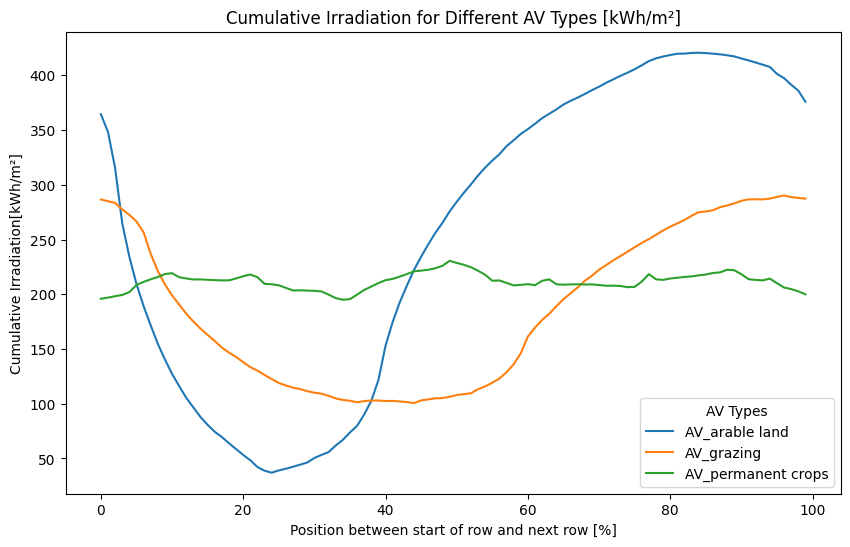

In [66]:
# Comparision of shadow profiles for different AV types
plt.figure(figsize=(10, 6))

for type in tqdm(AV_types):
    lat_4326 = gdf.loc[0,"lat_4326"]
    long_4326= gdf.loc[0,"long_4326"]
    track =         input.loc["tracking",type] 
    pvrow_azimuth = input.loc["pvrow_azimuth",type] 
    pvrow_tilt =    input.loc["pvrow_tilt",type] 
    pvrow_width =   input.loc["pvrow_width",type] 
    pvrow_height =  input.loc["pvrow_height",type]   
    pvrow_pitch =   input.loc["pvrow_distance",type] 
    bifaciality =   input.loc["bifaciality",type]

    # meta data dict (for bifacial vf sim)
    meta = {
        'state-prov': gdf.loc[i,"lat_4326"],
        'country': 'CHL',
        'latitude': lat_4326,
        'longitude': long_4326,
        'altitude': gdf.loc[i,"altitude"],
        'TZ': -4.0,
        'AV_type': type}
    
    # path for result
    writefiletitle = os.path.join(path_vf, str(lat_4326)+"_"+str(long_4326)+'.csv')

    # Get TMY file
    cord = str(lat_4326)+"_"+str(long_4326)
    tmy_path = next((file for file in tmy_files if cord in file), None)
    tmy = load_TMY(tmy_path)
    myTMY3 = prep_TMY_vf(tmy)
    simulate_vf(myTMY3, meta, writefiletitle=writefiletitle, 
                    tilt=pvrow_tilt, sazm=pvrow_azimuth, pitch=pvrow_pitch/pvrow_width, clearance_height=pvrow_height/pvrow_width, 
                    rowType=rowType, transFactor=transFactor, sensorsy=sensorsy, 
                    PVfrontSurface=PVfrontSurface, PVbackSurface=PVbackSurface, 
                    albedo=albedo, tracking=track, backtrack=track, 
                    limit_angle=pvrow_tilt, deltastyle=deltastyle, agriPV=agriPV, spacing_analisis=False, shadow_only=True, fix_csr=fix_csr)
    
    data, groundIrrads, df = read_vf_result(resultfilepath=writefiletitle)
    df_p = groundIrrads.groupby([pd.Grouper(freq='M')]).mean().T
    
    # Plotting: add the current type's data to the same plot
    df_p_mean = df_p.mean(axis=1)
    plt.plot(df_p_mean, label=type)  # Plot with label

# Configure the plot
plt.xlabel('Position between start of row and next row [%]')
plt.ylabel('Cumulative Irradiation[kWh/m²]')
plt.title('Cumulative Irradiation for Different AV Types [kWh/m²]')
plt.legend(title='AV Types')  # Add legend

# Show the plot
plt.show()

In [41]:

# Iteration over points in gdf for shadow analisis
for i in tqdm(gdf.index):
    # get meta data
    lat_4326 = gdf.loc[i,"lat_4326"]
    long_4326= gdf.loc[i,"long_4326"]
    
    # get AV data
    type =          gdf.loc[i,"AV_type"]
    track =         input.loc["tracking",type] 
    pvrow_azimuth = input.loc["pvrow_azimuth",type] 
    pvrow_tilt =    input.loc["pvrow_tilt",type] 
    pvrow_width =   input.loc["pvrow_width",type] 
    pvrow_height =  input.loc["pvrow_height",type]   
    pvrow_pitch =   input.loc["pvrow_distance",type] 
    bifaciality =   input.loc["bifaciality",type] 

    # meta data dict (for bifacial vf sim)
    meta = {
        'state-prov': gdf.loc[i,"lat_4326"],
        'country': 'CHL',
        'latitude': lat_4326,
        'longitude': long_4326,
        'altitude': gdf.loc[i,"altitude"],
        'TZ': -4.0,
        'AV_type': type}
    
    # path for result
    writefiletitle = os.path.join(path_vf, str(lat_4326)+"_"+str(long_4326)+'.csv')

    # Get TMY file
    cord = str(lat_4326)+"_"+str(long_4326)
    tmy_path = next((file for file in tmy_files if cord in file), None)
    tmy = load_TMY(tmy_path)
    myTMY3 = prep_TMY_vf(tmy)

    # Shadow Analisis 
    if optimize_pitch:
        # Run the optimization to find the optimal factor for row distance that minimizes the PAR shadow efficiency
        result = minimize_scalar(simulate_vf_par_shadow_opti, bounds=(0.5, 3), method='bounded', tol=0.02,
                            args=(myTMY3, meta, writefiletitle, pvrow_tilt, pvrow_azimuth, pvrow_pitch, pvrow_width, pvrow_height,
                                rowType, transFactor, sensorsy, "glass", "bifacial", albedo, track, deltastyle, agriPV, fix_csr, 
                                    PAR_ratio, W_PAR_conversion_factor, LSP, DLI, max_PAR_shadow))

        # Check the optimization result
        if result.success:
            pvrow_pitch = result.x * pvrow_pitch
            gdf.loc[i,"pvrow_pitch"] = pvrow_pitch 
    
    else: 
        # shadow simulation with pvrow_pitch from input
        simulate_vf(myTMY3, meta, writefiletitle=writefiletitle, 
                    tilt=pvrow_tilt, sazm=pvrow_azimuth, pitch=pvrow_pitch/pvrow_width, clearance_height=pvrow_height/pvrow_width, 
                    rowType=rowType, transFactor=transFactor, sensorsy=sensorsy, 
                    PVfrontSurface=PVfrontSurface, PVbackSurface=PVbackSurface, 
                    albedo=albedo, tracking=track, backtrack=track, 
                    limit_angle=pvrow_tilt, deltastyle=deltastyle, agriPV=agriPV, spacing_analisis=False, shadow_only=True, fix_csr=fix_csr)
        gdf.loc[i,"pvrow_pitch"] = pvrow_pitch
    
    # Calculation of GCR and Density
    gdf.loc[i, "GCR"] = round(pvrow_width  / pvrow_pitch,3)
    if tracking == True:
        real_pvwidth = pvrow_width
    else:
        real_pvwidth = pvrow_width * math.cos(math.radians(pvrow_tilt))
    gdf.loc[i, "GCR_real"] = round(real_pvwidth / pvrow_pitch,3)
    gdf.loc[i, "Density_kWp_ha"] =  gdf.loc[i, "GCR"] * PV_W_per_m2 *10



    # post processing of ground irradiation data
    data, groundIrrads, df = read_vf_result(resultfilepath=writefiletitle)
    
    # PAR calculations
    df = pd.concat([df, ghi_to_PAR(df, ratio = PAR_ratio, conversion_factor=W_PAR_conversion_factor)], axis=1) 
    df = apply_LSP(df, LSP)
    df_d = PAR_integral(df)
    df_d = apply_DLI(df_d, DLI)

    # Light homogenity index
    lhi = get_LHI(groundIrrads.groupby([pd.Grouper(freq='M')]).mean().T)

    gdf.loc[i,"ghi"] = data["ghi"].groupby([pd.Grouper(freq='D')]).sum().mean().round(2)
    gdf.loc[i,"ghi_AV"] = groundIrrads.mean(axis=1).groupby([pd.Grouper(freq='D')]).sum().mean().round(2)
    #gdf.loc[i,"PAR"] = df_d["PAR"].mean()
    #gdf.loc[i,"PAR_AV"] = df_d["PAR_apv"].mean()
    gdf.loc[i,"PAR_eff"] = df_d["PAR_LSP_DLI"].mean()
    gdf.loc[i,"PAR_eff_AV"] = df_d["PAR_apv_LSP_DLI"].mean()
    gdf.loc[i,"LHI_AV"] = lhi

for type in AV_types:
    gdf["ghi_shadow_AV"] = 1 - (1 / gdf["ghi"] * gdf["ghi_AV"])
    gdf["par_eff_shadow_AV"] = 1 - (1 / gdf["PAR_eff"] * gdf["PAR_eff_AV"])


 15%|█▌        | 3/20 [01:31<08:56, 31.57s/it]

In [42]:
gdf

,index,lat_4326,long_4326,region,geometry,desert,preci_mm,preci_a_mm,agri_area,arable land_area,...,GCR,GCR_real,Density_kWp_ha,ghi,ghi_AV,PAR_eff,PAR_eff_AV,LHI_AV,ghi_shadow_AV,par_eff_shadow_AV
0,0,-33.90,-71.49,Metropolitana de Santiago,POINT (269516.334 6245944.838),Grave,454.3,-3.2,1.433710e+08,927.73,...,0.428,0.328,881.806054,5403.96,2970.83,11.785194,10.584838,39.81,0.450249,0.101853
1,1,-33.91,-71.28,Metropolitana de Santiago,POINT (289516.334 6245944.838),Leve,430.4,1.6,9.826971e+07,2340.46,...,0.437,0.335,900.348705,5632.96,3040.01,11.853310,10.701870,39.46,0.460317,0.097141
2,2,-33.73,-71.27,Metropolitana de Santiago,POINT (289516.334 6265944.838),Leve,387.4,-1.7,2.077199e+08,1287.90,...,0.432,0.331,890.047232,5622.75,3067.59,11.854841,10.707535,40.36,0.454432,0.096780
3,3,-33.55,-71.27,Metropolitana de Santiago,POINT (289516.334 6285944.838),Leve,375.6,-4.8,1.781258e+08,1743.97,...,0.439,0.336,904.469294,5688.22,3050.43,11.816235,10.616735,39.85,0.463729,0.101513
4,4,-34.09,-71.06,Metropolitana de Santiago,POINT (309516.334 6225944.838),Grave,479.5,-1.0,3.297000e+07,538.99,...,0.420,0.321,865.323698,5274.12,2963.78,11.719537,10.522238,40.41,0.438052,0.102163
5,5,-33.91,-71.06,Metropolitana de Santiago,POINT (309516.334 6245944.838),Grave,479.5,-1.0,5.982202e+06,340.42,...,0.508,0.508,1046.629616,5296.59,2599.32,11.856358,11.210415,21.31,0.509247,0.054481
6,6,-33.73,-71.06,Metropolitana de Santiago,POINT (309516.334 6265944.838),S/I,430.4,1.6,1.570026e+08,2825.65,...,0.426,0.327,877.685465,5557.17,3044.34,11.810198,10.598062,37.48,0.452178,0.102635
7,7,-33.55,-71.05,Metropolitana de Santiago,POINT (309516.334 6285944.838),Leve,327.5,-4.4,1.944763e+08,2631.67,...,0.425,0.325,875.625171,5128.04,2839.80,11.801382,10.652841,37.47,0.446221,0.097323
8,8,-33.37,-71.05,Metropolitana de Santiago,POINT (309516.334 6305944.838),Leve,327.5,-4.4,5.346659e+07,681.49,...,0.431,0.331,887.986938,5708.83,3125.48,11.894296,10.742872,37.27,0.452518,0.096805
9,9,-33.91,-70.84,Metropolitana de Santiago,POINT (329516.334 6245944.838),Leve,377.1,-5.4,8.586501e+07,765.00,...,0.425,0.325,875.625171,5305.51,2920.61,11.735385,10.541513,39.21,0.449514,0.101733


3.2. - PV yield simulation

In [43]:
# Get info on available csv files
directory_TMYs="data\\PVGIS_TMY\\"
path = home+"\\"+directory_TMYs
tmy_files = glob.glob(path + "\*.csv")


# Run simulation for all entries in gdf with local TMYs
for i in tqdm(gdf.index):
    # set index
    lat_4326 = gdf.loc[i,"lat_4326"]
    long_4326= gdf.loc[i,"long_4326"]
    cord = str(lat_4326)+"_"+str(long_4326)
    tmy_path = next((file for file in tmy_files if cord in file), None)
    tmy = load_TMY(tmy_path)

    # Inputs for PV simulation
    case = gdf.loc[i,"AV_type"]
    track =         input.loc["tracking",case] 
    pvrow_azimuth = input.loc["pvrow_azimuth",case] 
    pvrow_tilt =    input.loc["pvrow_tilt",case] 
    pvrow_height =  input.loc["pvrow_height",case] 
    pvrow_width =   gdf.loc[i,"pvrow_pitch"]
    pvrow_pitch =   input.loc["pvrow_distance",case] 
    bifaciality =   input.loc["bifaciality",case] 
    n_pvrows = 3

    tmy["AV_ac_W"] = av.calc_PV(tmy, albedo, track, pvrow_azimuth, pvrow_tilt, n_pvrows, pvrow_width, pvrow_pitch, pvrow_height, bifaciality=bifaciality, losses= None)
    gdf.loc[((gdf["long_4326"] == long_4326) & (gdf["lat_4326"] == lat_4326)), "AV_ac_kWh_a"] = tmy["AV_ac_W"].sum()/1000
    #tmy.to_csv(tmy_path, sep=',',encoding='latin-1', index=False)

100%|██████████| 20/20 [02:05<00:00,  6.29s/it]


3.3. - Evapotranspiration Simulation based on AV GHI shadow

In [44]:
## Evapotranspiation
# Run simulation for all entries in gdf with local TMYs
for i in tqdm(gdf.index):
    lat_4326 = gdf.loc[i,"lat_4326"]
    long_4326= gdf.loc[i,"long_4326"]
    cord = str(lat_4326)+"_"+str(long_4326)
    tmy_path = next((file for file in tmy_files if cord in file), None)
    tmy = load_TMY(tmy_path)
    ele = gdf.loc[i,"altitude"]
    tmy["ET_0_mm_ref"] = av.calc_ET(tmy, lat_4326, ele, apv_shading=0)
    gdf.loc[i, "ET_0_mm"] = tmy["ET_0_mm_ref"].sum()

    # Inputs for PV simulation
    case = gdf.loc[i,"AV_type"]
    av_shadow = gdf.loc[i,'ghi_shadow_AV']
    tmy["ET_0_mm_AV"] = av.calc_ET(tmy, lat_4326, ele, apv_shading=av_shadow)
    gdf.loc[i, "ET_0_mm_AV"] = tmy["ET_0_mm_AV"].sum()
    tmy.reset_index(drop=True).to_csv(tmy_path, sep=',',encoding='latin-1', index=True)
gdf["ET_save_mm"] = gdf["ET_0_mm"] - gdf["ET_0_mm_AV"]

100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


3.4. - LCOE

In [45]:
# ECONOMIC PARAMETERS
# Tecnical Parameters
degre = 0.005                   # Degredatio of PV system [%]

# financial parameters
wacc = 0.1125                     # Weighted average cost of capital
inflation = 0.038                # Inflation
tax = 0.316                      # Corperate tax rate 
N = 25                          # Lifetime of AV system


kWp = 1

for i in tqdm(gdf.index):
    type = gdf.loc[i,"AV_type"]
    E_G = gdf.loc[i,"AV_ac_kWh_a"]
    CAPEX = input.loc["capex",type] * kWp                    # Specific Capital Expenditure in [USD per kWp]
    OPEX = input.loc["opex",type] * kWp
    gdf.loc[i,"LCOE"] = av.calc_LCOE(E_G=E_G, CAPEX=CAPEX, OPEX=OPEX, wacc=wacc, degre = degre, inflation = inflation, N = N) * 1000

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 126.56it/s]


3.5. - Plot result

In [46]:
gdf.columns

Index(['index', 'lat_4326', 'long_4326', 'region', 'geometry', 'desert',
       'preci_mm', 'preci_a_mm', 'agri_area', 'arable land_area',
       'grazing_area', 'permanent crops_area', 'PVGIS_dl', 'altitude',
       'GHI_KWh/a', 'AV_type', 'pvrow_pitch', 'GCR', 'GCR_real',
       'Density_kWp_ha', 'ghi', 'ghi_AV', 'PAR_eff', 'PAR_eff_AV', 'LHI_AV',
       'ghi_shadow_AV', 'par_eff_shadow_AV', 'AV_ac_kWh_a', 'ET_0_mm',
       'ET_0_mm_AV', 'ET_save_mm', 'LCOE'],
      dtype='object')

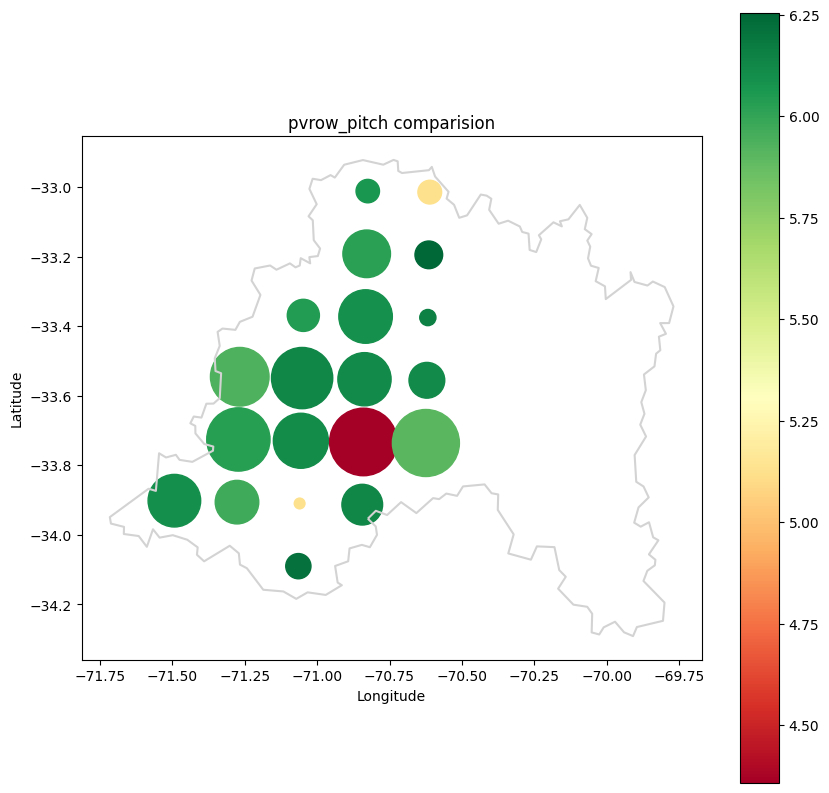

In [53]:
# Plot result for one the criteria above
criteria = 'pvrow_pitch' # gdf column name 
ax = gdf.to_crs(crs_i).plot(figsize=(10, 10),markersize=gdf['agri_area']/100000, column=criteria, cmap='RdYlGn', legend=True)
gdf_cl.to_crs(crs_i).boundary.plot(ax=ax, edgecolor="lightgrey")

plt.title(criteria+" comparision")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

4 - MCDM

In [48]:
def get_fuzzy(column,min_or_max):
    column = column.astype(float)
    fuzzy = column.copy()
    min = column.min()
    max = column.max()
    for i in column.index:
        if min_or_max == "max":
            fuzzy[i] = 1 / (max-min) * (column[i]-min)
        else:
            fuzzy[i] = 1- (1 / (max-min) * (column[i]-min))
    return fuzzy

In [49]:
# Get fuzzy values for serveral columns
gdf["PV_fuzzy"] = get_fuzzy(gdf["AV_ac_kWh_a"],"max")
gdf["LCOE_fuzzy"] = get_fuzzy(gdf["LCOE"],"min")
gdf["ET_fuzzy"] = get_fuzzy(gdf["ET_save_mm"],"max")
gdf["Preci_fuzzy"] = get_fuzzy(gdf["preci_a_mm"],"min")
gdf["desert_fuzzy"] = np.where(gdf["desert"] == "Grave",1,np.where(gdf["desert"] == "Moderada",0.6,0.3))

# Calculate traditional MCDM
gdf["MCDM"] = 0.2 * gdf["PV_fuzzy"] + 0.1 * gdf["LCOE_fuzzy"] + 0.3 * gdf["ET_fuzzy"] + 0.3* gdf["Preci_fuzzy"] + 0.1 * gdf["desert_fuzzy"]

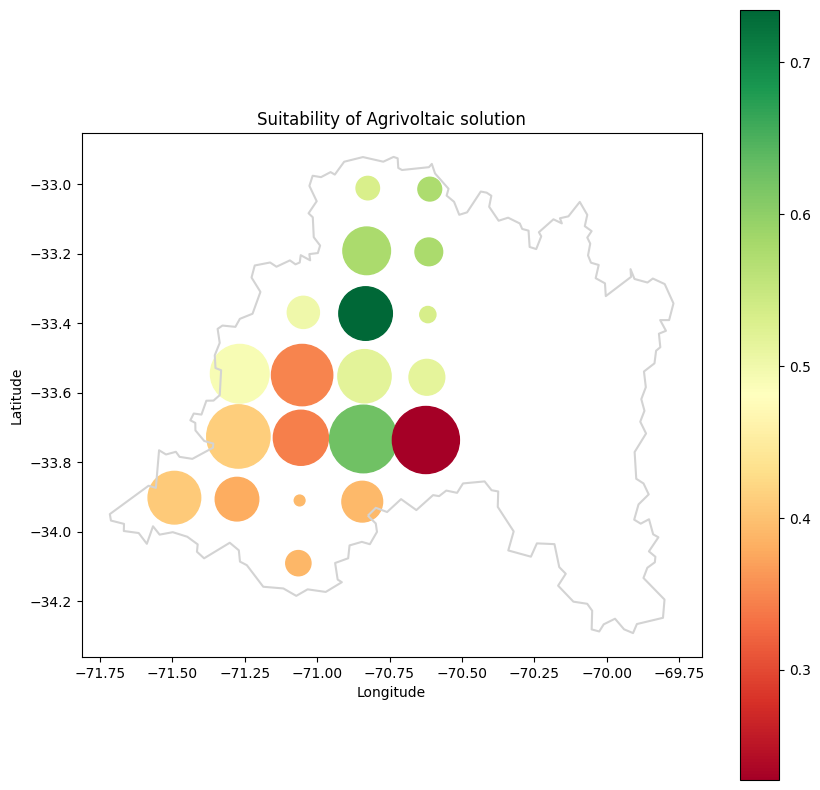

In [50]:
# Plot result
ax = gdf.to_crs(crs_i).plot(figsize=(10, 10),markersize=gdf['agri_area']/100000, column="MCDM", cmap='RdYlGn', legend=True)
gdf_cl.to_crs(crs_i).boundary.plot(ax=ax, edgecolor="lightgrey")

plt.title("Suitability of Agrivoltaic solution")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

4.1 - Context specific MCDM

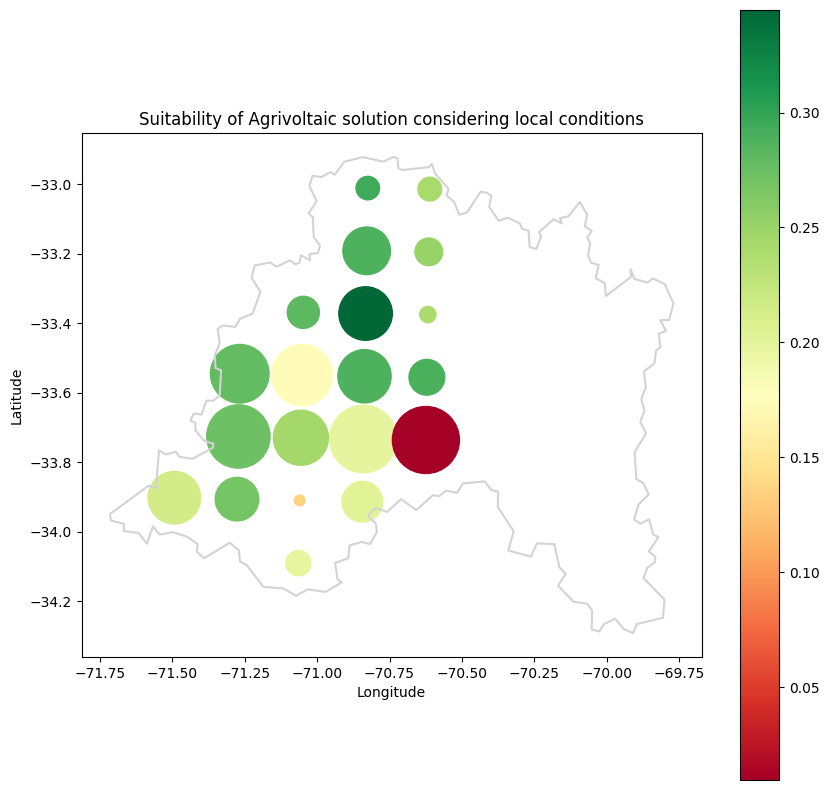

In [51]:
# Calculate context specific MCDM -> Evapotranspiration potential is weighted by desertification state and precipitation anomaly
gdf["MCDM_new"] = 0.2 * gdf["PV_fuzzy"] + 0.1 * gdf["LCOE_fuzzy"] + 0.3 * (gdf["ET_fuzzy"] * gdf["Preci_fuzzy"] * gdf["desert_fuzzy"])

# Plot shapefile of Chilean regions 
ax = gdf.to_crs(crs_i).plot(figsize=(10, 10),markersize=gdf['agri_area']/100000, column="MCDM_new", cmap='RdYlGn', legend=True)
gdf_cl.to_crs(crs_i).boundary.plot(ax=ax, edgecolor="lightgrey")

plt.title("Suitability of Agrivoltaic solution considering local conditions")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [52]:
gdf

,index,lat_4326,long_4326,region,geometry,desert,preci_mm,preci_a_mm,agri_area,arable land_area,...,ET_0_mm_AV,ET_save_mm,LCOE,PV_fuzzy,LCOE_fuzzy,ET_fuzzy,Preci_fuzzy,desert_fuzzy,MCDM,MCDM_new
0,0,-33.90,-71.49,Metropolitana de Santiago,POINT (269516.334 6245944.838),Grave,454.3,-3.2,1.433710e+08,927.73,...,1064.668188,281.135434,69.385397,0.634459,0.873455,0.000000,3.116883e-01,1.0,0.407744,0.214237
1,1,-33.91,-71.28,Metropolitana de Santiago,POINT (289516.334 6245944.838),Leve,430.4,1.6,9.826971e+07,2340.46,...,1024.915916,324.112857,65.412301,0.870440,0.957716,0.263490,1.110223e-16,0.3,0.378907,0.269860
2,2,-33.73,-71.27,Metropolitana de Santiago,POINT (289516.334 6265944.838),Leve,387.4,-1.7,2.077199e+08,1287.90,...,968.467846,308.206775,65.436983,0.868886,0.957193,0.165972,2.142857e-01,0.3,0.413574,0.272697
3,3,-33.55,-71.27,Metropolitana de Santiago,POINT (289516.334 6285944.838),Leve,375.6,-4.8,1.781258e+08,1743.97,...,911.482634,317.204391,65.390188,0.871834,0.958185,0.221135,4.155844e-01,0.3,0.491201,0.278456
4,4,-34.09,-71.06,Metropolitana de Santiago,POINT (309516.334 6225944.838),Grave,479.5,-1.0,3.297000e+07,538.99,...,875.310665,308.454619,71.327012,0.528700,0.832277,0.167491,1.688312e-01,1.0,0.389864,0.197451
5,5,-33.91,-71.06,Metropolitana de Santiago,POINT (309516.334 6245944.838),Grave,479.5,-1.0,5.982202e+06,340.42,...,864.020652,350.161347,72.528815,0.160658,0.806789,0.423191,1.688312e-01,1.0,0.390417,0.134245
6,6,-33.73,-71.06,Metropolitana de Santiago,POINT (309516.334 6265944.838),S/I,430.4,1.6,1.570026e+08,2825.65,...,939.277636,318.635389,67.180840,0.761951,0.920209,0.229909,1.110223e-16,0.3,0.343384,0.244411
7,7,-33.55,-71.05,Metropolitana de Santiago,POINT (309516.334 6285944.838),Leve,327.5,-4.4,1.944763e+08,2631.67,...,926.393288,297.328593,72.785687,0.452958,0.801341,0.099279,3.896104e-01,0.3,0.347392,0.174207
8,8,-33.37,-71.05,Metropolitana de Santiago,POINT (309516.334 6305944.838),Leve,327.5,-4.4,5.346659e+07,681.49,...,914.144243,326.790727,65.294338,0.877886,0.960218,0.279908,3.896104e-01,0.3,0.502455,0.281414
9,9,-33.91,-70.84,Metropolitana de Santiago,POINT (329516.334 6245944.838),Leve,377.1,-5.4,8.586501e+07,765.00,...,866.248255,294.802556,70.486864,0.573747,0.850095,0.083792,4.545455e-01,0.3,0.391260,0.203187
